# Task -2: Classifying Text into Counter and Non Counter Class using cross community predictions
### This notebook is used to measure the performance of using two community for training and one community for testing  out of the three communities.

In [25]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score, classification_report, precision_recall_fscore_support
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from collections import Counter
from string import punctuation
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import neighbors
from sklearn import ensemble
from sklearn import neural_network
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
import pickle
from nltk.stem.porter import *
ps = PorterStemmer()
from scipy.sparse import vstack, hstack


#### This function will return the plot of the confusion matrix 
1. input: confusion matrix and target names(class_name)
2. output: plot of confusion matrix 

In [2]:
# file used to write preserve the results of the classfier
# confusion matrix and precision recall fscore matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    return plt

#### This function is generating the classification report
1. input: ground_truth and predicted outputs
2. output: dataframe containing the results

In [3]:
##saving the classification report
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='macro'))
    avg.append(accuracy_score(y_true, y_pred, normalize=True))
    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support','accuracy']
    list_all=list(metrics_summary)
    list_all.append(cm.diagonal())
    class_report_df = pd.DataFrame(
        list_all,
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-2] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

## Dataset is loaded here

In [4]:
### change the path where the data is kept
path='../Data/Counterspeech_Dataset.json'
with open(path) as fp:
    train_data = json.load(fp)

In [5]:
def convert_class_label(input_text):
    if input_text:
        return 'counter'
    else:
        return 'noncounter'

In [6]:
pd_train = pd.DataFrame(columns=['id','class','community','category','text'])

for count, each in enumerate(train_data):
    try:
        pd_train.loc[count]  = [each['id'], convert_class_label(each['CounterSpeech']), each['Community'],each['Category'],each['commentText']]
    except:
        pass
print('Training Data Loading Completed...')

Training Data Loading Completed...


In [7]:
from commen_preprocess import *

....start....cleaning


In [8]:
pd_train['text'].replace('', np.nan, inplace=True)
pd_train.dropna(subset=['text'], inplace=True)
pd_train.head()

,id,class,community,category,text
0,Ugw-_mfnTo9SUniGGTN4AaABAg,noncounter,jews,Default,she is one of the last brave white women with ...
1,UgiMOgO3u4akkngCoAEC,noncounter,lgbt,Default,AMEN PASTOR!!!!!!!!
2,UgzemCMbg-ri1ri7sCt4AaABAg,counter,jews,"2,8",What kind of God is it that Hates people & Cur...
3,UghFhzrURF1svHgCoAEC,counter,jews,8,Question - Which comment is racist and why?\n ...
4,Ugzr50sQdH0Ictuex214AaABAg,counter,jews,8,That Israel fail that is nothing new. That Isr...


In [9]:
pd_train.head()

,id,class,community,category,text
0,Ugw-_mfnTo9SUniGGTN4AaABAg,noncounter,jews,Default,she is one of the last brave white women with ...
1,UgiMOgO3u4akkngCoAEC,noncounter,lgbt,Default,AMEN PASTOR!!!!!!!!
2,UgzemCMbg-ri1ri7sCt4AaABAg,counter,jews,"2,8",What kind of God is it that Hates people & Cur...
3,UghFhzrURF1svHgCoAEC,counter,jews,8,Question - Which comment is racist and why?\n ...
4,Ugzr50sQdH0Ictuex214AaABAg,counter,jews,8,That Israel fail that is nothing new. That Isr...


### Google Universal Sentence Encoder configuration
###### prerequisite: tensorflow version >=1.7

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
embed = hub.Module(module_url)
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=12,
                       allow_soft_placement=True, device_count = {'CPU': 12})

def get_embeddings(messages):
      
    with tf.Session(config=config) as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            message_emb = session.run(embed(messages))
            
    print("ending")
    return np.array(message_emb)

/home/binny/anaconda3/envs/punyajoy-nogpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_0:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/variables/variables' with Embeddings_en/sharded_0
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_1:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/variables/variables' with Embeddings_en/sharded_1
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_10:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/variables/variables' with Embeddings_en/sharded_10
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_11:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/variables/variables' with Embeddings_en/sharded_11
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_12:0 from checkpoint b'/tmp/tfhub_modules/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/v

In [18]:
#### converting the data into text and labels dictionary

def get_data(pd_train):
    comments=pd_train['text'].values
    labels=pd_train['class'].values
    list_comment=[]
    for comment,label in zip(comments,labels):
        temp={}
        temp['text']=comment
        temp['label']=label
        list_comment.append(temp)
    return list_comment    

#### Different type of tokenization that can be performed

In [19]:
### stopwords and punctuations are not removed but text is cleaned and stemmed
def glove_tokenize_norem(text):
    #text = tokenizer(text)
    text=clean(text, remove_stopwords=False, remove_punctuations=False)
    words = text.split()
    words =[ps.stem(word) for word in words]
    return words

####stopwords and punctuations are removed along with that text is cleaned and stemmed
def glove_tokenize(text):
    #text = tokenizer(text)
    text=clean(text, remove_stopwords=False, remove_punctuations=False)
    text = ''.join([c for c in text if c not in punctuation])
    words = text.split()
    words = [word for word in words if word not in STOPWORDS]
    words =[ps.stem(word) for word in words]
    return words


### Different feature generation methods


In [20]:
TOKENIZER = glove_tokenize
#google encoding used where text is cleaned  
def gen_data_google(data):
    comments = get_data(data)
    X, y = [], []
    for comment in comments:
        y.append(comment['label'])
        #X.append(tokenizer(comment['text']))
        X.append(clean(comment['text'], remove_stopwords=True, remove_punctuations=True))
    
    X =get_embeddings(X)
    return X, y

#google encoding used where text is not cleaned 
def gen_data_google2(data):
    comments = get_data(data)
    X, X1, y = [],[],[]
    for comment in comments:
        y.append(comment['label'])
        X.append(clean(comment['text'], remove_stopwords=False, remove_punctuations=False))
    #Word Level Features
    X =get_embeddings(X)
    return X,y

### tfidf feature generation was used here where stopwords and punctuations are removed 
def gen_data_new_tfidf(data):
    comments = get_data(data)
    X, y = [], []
    for comment in comments:
        y.append(comment['label'])
        X.append(comment['text'])
    with open('tfidf_word_vectorizer.pk', 'rb') as fin:
        word_vectorizer = pickle.load(fin)

    with open('tfidf_char_vectorizer.pk', 'rb') as fin:
        char_vectorizer = pickle.load(fin)


    test_word_features = word_vectorizer.transform(X)
    test_char_features = char_vectorizer.transform(X)
    X = list(hstack([test_char_features, test_word_features]).toarray())
    return X, y




## combination of not cleaned google encodings and tfidf features where stopwords and punctuations are not removed 
def combine_tf_google_rem(data):
    X,_=gen_data_google(data)
    X1,y=gen_data_new_tfidf(data)
    X=np.concatenate((np.array(X), np.array(X1)), axis=1)
    return X,y

## combination of cleaned google encodings and tfidf features where stopwords and punctuations are ssremoved 
def combine_tf_google_norem(data):
    X,_=gen_data_google2(data)
    X1,y=gen_data_new_tfidf2(data)
    X=np.concatenate((np.array(X), np.array(X1)), axis=1)
    return X,y
## combination of google encodings where stopwords and punctuation are kept and tfidf features where stopwords and punctuations are removed 
def combine_tf_rem_google_norem(data):
    X,_=gen_data_google2(data) 
    X1,y=gen_data_new_tfidf(data)
    X=np.concatenate((np.array(X), np.array(X1)), axis=1)
    return X,y
## combination of google encodings where stopwords and punctuation are removed and tfidf features where stopwords and punctuations are kept 
def combine_tf_norem_google_rem(data):
    X,_=gen_data_google(data)
    X1,y=gen_data_new_tfidf2(data)
    X=np.concatenate((np.array(X), np.array(X1)), axis=1)
    return X,y


###old tfidf

def gen_data_old_tfidf(data):
    comments = get_data(data)
    X, y = [], []
    for comment in comments:
        y.append(comment['label'])
        X.append(comment['text'])
    with open('../tfidf_word_vectorizer.pk', 'rb') as fin:
        word_vectorizer = pickle.load(fin)

    with open('../tfidf_char_vectorizer.pk', 'rb') as fin:
        char_vectorizer = pickle.load(fin)


    
    word_vectorizer.fit(X)
    char_vectorizer.fit(X)
    
    test_word_features = word_vectorizer.transform(X)
    test_char_features = char_vectorizer.transform(X)
    X = list(hstack([test_char_features, test_word_features]).toarray())
    
    return X, y


In [21]:
###division of training set into three parts corresponding to various community 
part_j=pd_train.loc[pd_train['community']=='jews']
part_b=pd_train.loc[pd_train['community']=='black']
part_l=pd_train.loc[pd_train['community']=='lgbt']



## Model selection and feature selection 

In [22]:
def get_model(m_type=None):
    if not m_type:
        print("ERROR: Please specify a model type!")
        return None
    if m_type == 'decision_tree_classifier':
        logreg = tree.DecisionTreeClassifier(class_weight='balanced')
    elif m_type == 'MLPClassifier':
        logreg = neural_network.MLPClassifier((500))
    elif m_type == 'KNeighborsClassifier':
        logreg = neighbors.KNeighborsClassifier(n_neighbors = 10)
    elif m_type == 'ExtraTreeClassifier':
        logreg = tree.ExtraTreeClassifier()
    elif m_type == 'ExtraTreeClassifier_2':
        logreg = ensemble.ExtraTreesClassifier()
    elif m_type == 'RandomForestClassifier':
        logreg = ensemble.RandomForestClassifier(class_weight='balanced')
    elif m_type == 'Logistic_Regression':
        logreg = OneVsRestClassifier(linear_model.LogisticRegression(class_weight='balanced'))
    elif m_type == 'SVC':
        logreg = SVC(class_weight='balanced');
    elif m_type == 'Catboost':
        logreg = CatBoostClassifier()
    elif m_type == 'XGB_classifier_default':
        logreg=XGBClassifier(n_estimators=500,nthread=12)
    elif m_type == 'Gaussian_NB':
        logreg = GaussianNB()
    else:
        print("give correct model")
    return logreg

def get_feature(f_type=None,data=None):
    if not f_type:
        print("ERROR: Please specify a model type!")
        return None
    if f_type == 'google_not_preprocess':
        X,y=gen_data_google2(data)
    elif f_type == 'google_preprocess':
        X,y=gen_data_google(data)
    elif f_type == 'tfidf_not_preprocess':
        X,y=gen_data_new_tfidf2(data)
    elif f_type == 'tfidf_preprocess':
        X,y=gen_data_new_tfidf(data)
    elif f_type == 'google_preprocess_tfidf_preprocess':
        X,y=combine_tf_google_rem(data)
    elif f_type == 'google_nopreprocess_tfidf_nopreprocess':
        X,y=combine_tf_google_norem(data)
    elif f_type == 'google_preprocess_tfidf_nopreprocess':
        X,y=combine_tf_norem_google_rem(data)
    elif f_type == 'google_nopreprocess_tfidf_preprocess':
        X,y=combine_tf_rem_google_norem(data)
    else:
        print("give correct feature selection")    
    return X,y


In [ ]:
import json
with open('binary_all_parameters.json') as f:
        parameters=json.load(f)

In [23]:
def classification(classifier_model,feature_model,train,test,confusion_name,report_name,pred_name_save):
    ###select data use individually for test and train methods described at the top
    X_train,y_train=get_feature(f_type=feature_model,data=train)
    X_test,y_test=get_feature(f_type=feature_model,data=test)
    classifier=get_model(classifier_model)
    try:
        model_parameter=parameters[classifier_model+'+'feature_model]
        for k,v in param_set.items():
            setattr(model_parameter,k,v)
    except:
        pass
      
    
    Classifier_Train_X = np.array(X_train, copy=False)
    Classifier_Train_Y = y_train
    Classifier_Test_X = np.array(X_test, copy=False)
    Classifier_Test_Y = y_test
    
    label_map = {
                'counter': 0,
                'noncounter': 1
            }
    temp=[]
    for data in Classifier_Train_Y:
            temp.append(label_map[data])

    Classifier_Train_Y=np.array(temp)


    temp=[]
    for data in Classifier_Test_Y:
            temp.append(label_map[data])

    Classifier_Test_Y=np.array(temp)
    classifier.fit(Classifier_Train_X,Classifier_Train_Y)
    y_pred = classifier.predict(Classifier_Test_X)
    y_pred_train = classifier.predict(Classifier_Train_X)
    print('accuracy_train:',accuracy_score(Classifier_Train_Y, y_pred_train),'accuracy_test:',accuracy_score(Classifier_Test_Y, y_pred))
    report = classification_report(Classifier_Train_Y , y_pred_train )
    print(report)
    report = classification_report(Classifier_Test_Y , y_pred )
    cm=confusion_matrix(Classifier_Test_Y, y_pred)
    plt=plot_confusion_matrix(cm,normalize= True,target_names = ['counter','non_counter'],title = "Confusion Matrix")
    plt.savefig(confusion_name)
    print(report)
    df_result=pandas_classification_report(Classifier_Test_Y,y_pred)
    df_result.to_csv(report_name,  sep=',')
    with open(pred_name_save, 'wb') as f:
            pickle.dump([Classifier_Test_Y,y_pred], f)


## Models available
1. decision_tree_classifier
2. MLPClassifier
3. KNeighborsClassifier
4. ExtraTreeClassifier
5. ExtraTreeClassifier_2
6. RandomForestClassifier
7. SVC
8. Catboost
9. XGB_classifier
10. Logistic Regression
11. Gaussian Naive bayes



## Feature Models available
1. google_not_preprocess
2. google_preprocess
3. tfidf_not_preprocess
4. tfidf_preprocess
5. google_preprocess_tfidf_preprocess
6. google_nopreprocess_tfidf_nopreprocess
7. google_preprocess_tfidf_nopreprocess
8. google_nopreprocess_tfidf_preprocess


## all_classification_task

ending
ending
Learning rate set to 0.02897
0:	learn: 0.6892730	total: 269ms	remaining: 4m 28s
1:	learn: 0.6867930	total: 450ms	remaining: 3m 44s
2:	learn: 0.6839960	total: 638ms	remaining: 3m 32s
3:	learn: 0.6809559	total: 807ms	remaining: 3m 20s
4:	learn: 0.6782721	total: 987ms	remaining: 3m 16s
5:	learn: 0.6752727	total: 1.15s	remaining: 3m 11s
6:	learn: 0.6729566	total: 1.32s	remaining: 3m 7s
7:	learn: 0.6704703	total: 1.51s	remaining: 3m 7s
8:	learn: 0.6679373	total: 1.7s	remaining: 3m 7s
9:	learn: 0.6653143	total: 1.89s	remaining: 3m 6s
10:	learn: 0.6633957	total: 2.05s	remaining: 3m 4s
11:	learn: 0.6612084	total: 2.23s	remaining: 3m 3s
12:	learn: 0.6595077	total: 2.39s	remaining: 3m 1s
13:	learn: 0.6576037	total: 2.57s	remaining: 3m 1s
14:	learn: 0.6555348	total: 2.73s	remaining: 2m 59s
15:	learn: 0.6533218	total: 2.91s	remaining: 2m 59s
16:	learn: 0.6515261	total: 3.09s	remaining: 2m 58s
17:	learn: 0.6496614	total: 3.27s	remaining: 2m 58s
18:	learn: 0.6477692	total: 3.43s	remain

158:	learn: 0.5361915	total: 26.9s	remaining: 2m 22s
159:	learn: 0.5357137	total: 27.1s	remaining: 2m 22s
160:	learn: 0.5351815	total: 27.3s	remaining: 2m 22s
161:	learn: 0.5346455	total: 27.5s	remaining: 2m 22s
162:	learn: 0.5341435	total: 27.6s	remaining: 2m 21s
163:	learn: 0.5337758	total: 27.8s	remaining: 2m 21s
164:	learn: 0.5333931	total: 27.9s	remaining: 2m 21s
165:	learn: 0.5328082	total: 28.1s	remaining: 2m 21s
166:	learn: 0.5322045	total: 28.3s	remaining: 2m 21s
167:	learn: 0.5319282	total: 28.4s	remaining: 2m 20s
168:	learn: 0.5315441	total: 28.6s	remaining: 2m 20s
169:	learn: 0.5310253	total: 28.8s	remaining: 2m 20s
170:	learn: 0.5305718	total: 28.9s	remaining: 2m 20s
171:	learn: 0.5300513	total: 29.1s	remaining: 2m 20s
172:	learn: 0.5297943	total: 29.3s	remaining: 2m 19s
173:	learn: 0.5293062	total: 29.5s	remaining: 2m 19s
174:	learn: 0.5287765	total: 29.6s	remaining: 2m 19s
175:	learn: 0.5281990	total: 29.8s	remaining: 2m 19s
176:	learn: 0.5276110	total: 29.9s	remaining: 

316:	learn: 0.4695094	total: 53.2s	remaining: 1m 54s
317:	learn: 0.4691286	total: 53.4s	remaining: 1m 54s
318:	learn: 0.4687817	total: 53.5s	remaining: 1m 54s
319:	learn: 0.4684086	total: 53.7s	remaining: 1m 54s
320:	learn: 0.4680051	total: 53.9s	remaining: 1m 53s
321:	learn: 0.4676157	total: 54s	remaining: 1m 53s
322:	learn: 0.4672680	total: 54.2s	remaining: 1m 53s
323:	learn: 0.4667773	total: 54.3s	remaining: 1m 53s
324:	learn: 0.4664101	total: 54.5s	remaining: 1m 53s
325:	learn: 0.4659503	total: 54.7s	remaining: 1m 53s
326:	learn: 0.4654125	total: 54.9s	remaining: 1m 52s
327:	learn: 0.4650047	total: 55s	remaining: 1m 52s
328:	learn: 0.4646645	total: 55.2s	remaining: 1m 52s
329:	learn: 0.4642492	total: 55.4s	remaining: 1m 52s
330:	learn: 0.4639475	total: 55.5s	remaining: 1m 52s
331:	learn: 0.4635411	total: 55.7s	remaining: 1m 52s
332:	learn: 0.4631931	total: 55.8s	remaining: 1m 51s
333:	learn: 0.4628160	total: 56s	remaining: 1m 51s
334:	learn: 0.4625279	total: 56.1s	remaining: 1m 51s

472:	learn: 0.4071807	total: 1m 19s	remaining: 1m 28s
473:	learn: 0.4069029	total: 1m 19s	remaining: 1m 28s
474:	learn: 0.4066350	total: 1m 19s	remaining: 1m 27s
475:	learn: 0.4062746	total: 1m 19s	remaining: 1m 27s
476:	learn: 0.4058826	total: 1m 19s	remaining: 1m 27s
477:	learn: 0.4054910	total: 1m 20s	remaining: 1m 27s
478:	learn: 0.4052048	total: 1m 20s	remaining: 1m 27s
479:	learn: 0.4048444	total: 1m 20s	remaining: 1m 27s
480:	learn: 0.4045292	total: 1m 20s	remaining: 1m 26s
481:	learn: 0.4041591	total: 1m 20s	remaining: 1m 26s
482:	learn: 0.4038230	total: 1m 20s	remaining: 1m 26s
483:	learn: 0.4035168	total: 1m 21s	remaining: 1m 26s
484:	learn: 0.4031282	total: 1m 21s	remaining: 1m 26s
485:	learn: 0.4029382	total: 1m 21s	remaining: 1m 26s
486:	learn: 0.4025138	total: 1m 21s	remaining: 1m 25s
487:	learn: 0.4022272	total: 1m 21s	remaining: 1m 25s
488:	learn: 0.4019171	total: 1m 21s	remaining: 1m 25s
489:	learn: 0.4015781	total: 1m 22s	remaining: 1m 25s
490:	learn: 0.4013158	total:

626:	learn: 0.3592736	total: 1m 44s	remaining: 1m 2s
627:	learn: 0.3588640	total: 1m 44s	remaining: 1m 2s
628:	learn: 0.3586138	total: 1m 45s	remaining: 1m 1s
629:	learn: 0.3584121	total: 1m 45s	remaining: 1m 1s
630:	learn: 0.3581486	total: 1m 45s	remaining: 1m 1s
631:	learn: 0.3579141	total: 1m 45s	remaining: 1m 1s
632:	learn: 0.3576431	total: 1m 45s	remaining: 1m 1s
633:	learn: 0.3573428	total: 1m 45s	remaining: 1m 1s
634:	learn: 0.3571510	total: 1m 45s	remaining: 1m
635:	learn: 0.3568466	total: 1m 46s	remaining: 1m
636:	learn: 0.3567162	total: 1m 46s	remaining: 1m
637:	learn: 0.3564074	total: 1m 46s	remaining: 1m
638:	learn: 0.3561057	total: 1m 46s	remaining: 1m
639:	learn: 0.3557436	total: 1m 46s	remaining: 1m
640:	learn: 0.3554873	total: 1m 46s	remaining: 59.9s
641:	learn: 0.3552055	total: 1m 47s	remaining: 59.8s
642:	learn: 0.3549513	total: 1m 47s	remaining: 59.6s
643:	learn: 0.3545723	total: 1m 47s	remaining: 59.4s
644:	learn: 0.3542454	total: 1m 47s	remaining: 59.3s
645:	learn:

784:	learn: 0.3171514	total: 2m 10s	remaining: 35.9s
785:	learn: 0.3168767	total: 2m 11s	remaining: 35.7s
786:	learn: 0.3166861	total: 2m 11s	remaining: 35.5s
787:	learn: 0.3164821	total: 2m 11s	remaining: 35.4s
788:	learn: 0.3163299	total: 2m 11s	remaining: 35.2s
789:	learn: 0.3161531	total: 2m 11s	remaining: 35s
790:	learn: 0.3157958	total: 2m 11s	remaining: 34.9s
791:	learn: 0.3154610	total: 2m 12s	remaining: 34.7s
792:	learn: 0.3152617	total: 2m 12s	remaining: 34.5s
793:	learn: 0.3149699	total: 2m 12s	remaining: 34.4s
794:	learn: 0.3148417	total: 2m 12s	remaining: 34.2s
795:	learn: 0.3144882	total: 2m 12s	remaining: 34s
796:	learn: 0.3143822	total: 2m 12s	remaining: 33.9s
797:	learn: 0.3140982	total: 2m 13s	remaining: 33.7s
798:	learn: 0.3137269	total: 2m 13s	remaining: 33.5s
799:	learn: 0.3134767	total: 2m 13s	remaining: 33.4s
800:	learn: 0.3132912	total: 2m 13s	remaining: 33.2s
801:	learn: 0.3130511	total: 2m 13s	remaining: 33s
802:	learn: 0.3128589	total: 2m 13s	remaining: 32.8s

940:	learn: 0.2823562	total: 2m 36s	remaining: 9.82s
941:	learn: 0.2821972	total: 2m 36s	remaining: 9.65s
942:	learn: 0.2820145	total: 2m 36s	remaining: 9.49s
943:	learn: 0.2818415	total: 2m 37s	remaining: 9.32s
944:	learn: 0.2816599	total: 2m 37s	remaining: 9.15s
945:	learn: 0.2814636	total: 2m 37s	remaining: 8.99s
946:	learn: 0.2812385	total: 2m 37s	remaining: 8.82s
947:	learn: 0.2810255	total: 2m 37s	remaining: 8.65s
948:	learn: 0.2808509	total: 2m 37s	remaining: 8.49s
949:	learn: 0.2806005	total: 2m 38s	remaining: 8.32s
950:	learn: 0.2803768	total: 2m 38s	remaining: 8.15s
951:	learn: 0.2801478	total: 2m 38s	remaining: 7.99s
952:	learn: 0.2799300	total: 2m 38s	remaining: 7.82s
953:	learn: 0.2797284	total: 2m 38s	remaining: 7.66s
954:	learn: 0.2795378	total: 2m 38s	remaining: 7.49s
955:	learn: 0.2792782	total: 2m 39s	remaining: 7.32s
956:	learn: 0.2789613	total: 2m 39s	remaining: 7.16s
957:	learn: 0.2787197	total: 2m 39s	remaining: 6.99s
958:	learn: 0.2785323	total: 2m 39s	remaining:

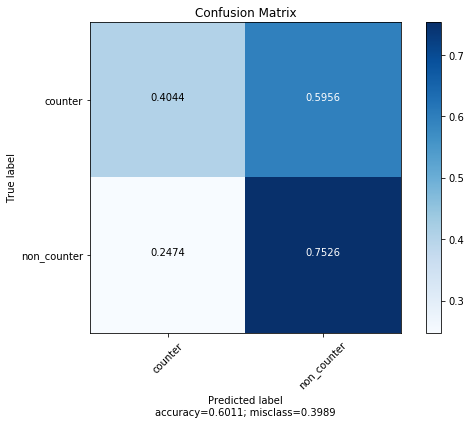

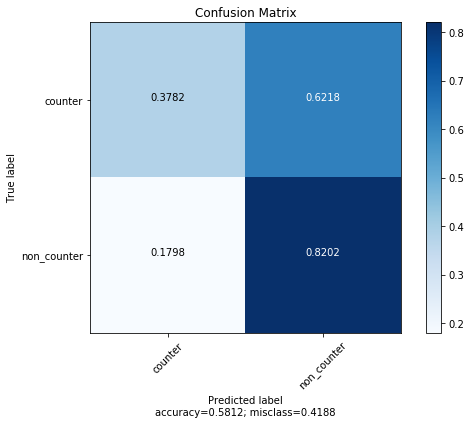

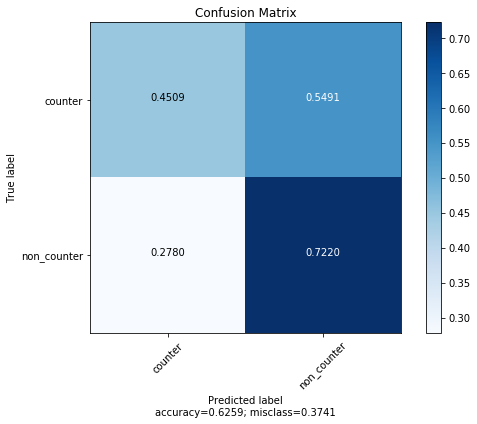

In [26]:
train = pd.concat([part_j,part_l])
test =  part_b
classification(classifier_model='Catboost',feature_model='google_preprocess_tfidf_preprocess',train=train,test=test,confusion_name='confusion_black_CB_gptp.png',report_name='confusion_black_CB_gptp.csv',pred_name_save='black_all_save.pkl')

print("complete one")

train = pd.concat([part_j,part_b])
test =  part_l
classification(classifier_model='MLPClassifier',feature_model='google_preprocess',train=train,test=test,confusion_name='confusion_lgbt_MLP_gp.png',report_name='confusion_lgbt_MLP_gp.csv',pred_name_save='lgbt_all_save.pkl')

print("complete two")

train = pd.concat([part_b,part_l])
test =  part_j
classification(classifier_model='MLPClassifier',feature_model='google_preprocess',train=train,test=test,confusion_name='confusion_jew_MLP_gp.png',report_name='confusion_jew_MLP_gp.csv',pred_name_save='jew_all_save.pkl')

print("complete three")
